### Using Metropolis-Hastings Algorithm for Estimation

The goal will be to estimate the parameters of a multivariate Gaussian distribution from a large dataset.

We will use Metropolis-Hastings MCMC to approximate the posterior distribution of μμ and ΣΣ given the data, where:

    Prior: We assume conjugate priors for μμ and ΣΣ:
        μ∼N(0,IM)μ∼N(0,IM​), where IMIM​ is the identity matrix.
        Σ−1∼W(IM,M)Σ−1∼W(IM​,M) (i.e., the inverse of the covariance follows a Wishart distribution).

    Likelihood: The likelihood function for a multivariate Gaussian is:
    p(X∣μ,Σ)=1(2π)M/2∣Σ∣1/2exp⁡(−12(X−μ)TΣ−1(X−μ))
    p(X∣μ,Σ)=(2π)M/2∣Σ∣1/21​exp(−21​(X−μ)TΣ−1(X−μ))

    Proposal Distribution: For simplicity, the proposal distribution for both μμ and ΣΣ can be Gaussian. We propose new values for μμ and ΣΣ from a normal distribution centered at the current parameter values.

    Acceptance Criterion: We accept or reject the proposed values using the Metropolis-Hastings acceptance rule:
    α=min⁡(1,p(proposed∣data)p(current∣data))
    α=min(1,p(current∣data)p(proposed∣data)​)

    Where p(⋅∣data)p(⋅∣data) is the posterior probability of the proposed and current parameter values given the data.

### Objective


- Estimate the posterior distribution of μμ and ΣΣ using the Metropolis-Hastings algorithm.
- Compare the estimated mean μμ and covariance ΣΣ with the true values used to generate the dataset.
- Visualize the MCMC trace for both μμ and ΣΣ, and plot the posterior distributions.

StatementMeta(, 3ebb37b1-7810-4b68-a61e-cf8b43381e4f, 4, Finished, Available, Finished)

True weights: [ 3.  -1.5  2. ]
Estimated weights (mean): [ 2.99078002 -1.51182858  1.94991654]
95% credible interval for weights: [[ 2.9473143  -1.59343188  1.88052423]
 [ 3.08574161 -1.45827346  2.03061917]]
True noise variance: 1.0
Estimated noise variance (mean): 1.0671245545412837
95% credible interval for noise variance: [0.97182412 1.17723706]
Acceptance rate: 0.05


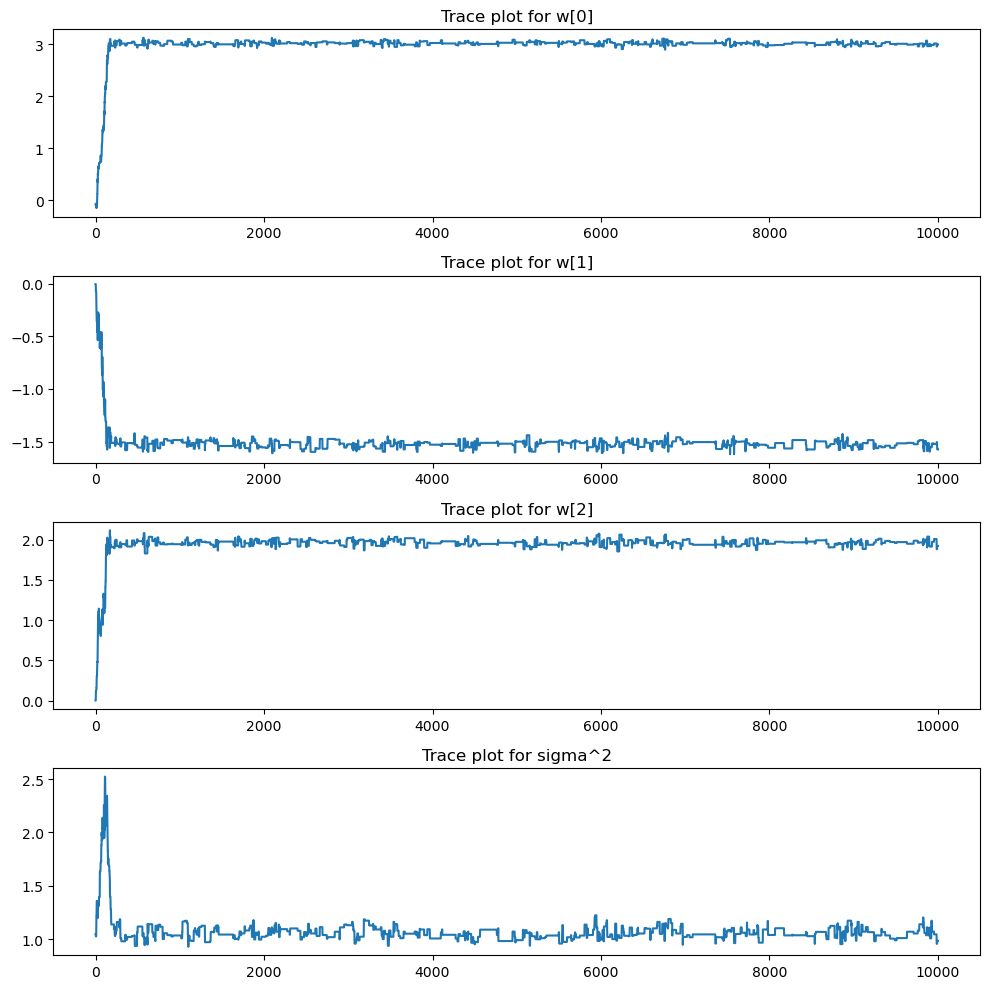

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

# Step 1: Generate synthetic data
np.random.seed(42)

# True parameters
w_true = np.array([3.0, -1.5, 2.0])
sigma2_true = 1.0  # True variance of the noise
N = 1000  # Number of data points
d = len(w_true)  # Number of features

# Generate synthetic dataset
X = np.random.randn(N, d)
epsilon = np.random.randn(N) * np.sqrt(sigma2_true)
y = X @ w_true + epsilon

# Step 2: Define Bayesian Linear Regression
# Prior for w ~ N(w_0, V_0) and sigma2 ~ Inv-Gamma(a_0, b_0)
w_0 = np.zeros(d)  # Prior mean of weights
V_0 = np.eye(d) * 10  # Prior variance of weights (diagonal for simplicity)
a_0 = 2.0  # Shape parameter of Inverse Gamma
b_0 = 1.0  # Scale parameter of Inverse Gamma

# Step 3: Metropolis-Hastings MCMC algorithm
def log_prior(w, sigma2):
    """Log-prior for weights and variance"""
    lp_w = norm.logpdf(w, w_0, np.sqrt(np.diag(V_0))).sum()
    lp_sigma2 = invgamma.logpdf(sigma2, a_0, scale=b_0)
    return lp_w + lp_sigma2

def log_likelihood(w, sigma2, X, y):
    """Log-likelihood of the data given parameters"""
    residuals = y - X @ w
    ll = -0.5 * N * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * (residuals ** 2).sum()
    return ll

def log_posterior(w, sigma2, X, y):
    """Log posterior = Log likelihood + Log prior"""
    return log_likelihood(w, sigma2, X, y) + log_prior(w, sigma2)

def metropolis_hastings(X, y, n_samples=5000, w_init=None, sigma2_init=1.0, step_size_w=0.1, step_size_sigma2=0.1):
    # Initial values
    w_current = np.copy(w_init)
    sigma2_current = sigma2_init

    samples_w = np.zeros((n_samples, d))
    samples_sigma2 = np.zeros(n_samples)
    
    accept_count = 0

    for i in range(n_samples):
        # Propose new weights
        w_proposal = w_current + np.random.randn(d) * step_size_w
        sigma2_proposal = sigma2_current + np.random.randn() * step_size_sigma2

        # Ensure sigma2 is positive
        if sigma2_proposal <= 0:
            continue
        
        # Compute log posterior for current and proposed states
        log_post_current = log_posterior(w_current, sigma2_current, X, y)
        log_post_proposal = log_posterior(w_proposal, sigma2_proposal, X, y)

        # Acceptance ratio
        log_accept_ratio = log_post_proposal - log_post_current
        if np.log(np.random.rand()) < log_accept_ratio:
            w_current = w_proposal
            sigma2_current = sigma2_proposal
            accept_count += 1

        # Store the samples
        samples_w[i] = w_current
        samples_sigma2[i] = sigma2_current

    acceptance_rate = accept_count / n_samples
    return samples_w, samples_sigma2, acceptance_rate

# Step 4: Run MCMC
n_samples = 10000
w_init = np.zeros(d)
sigma2_init = 1.0

samples_w, samples_sigma2, acceptance_rate = metropolis_hastings(X, y, n_samples, w_init, sigma2_init)

# Step 5: Analyze results
# Posterior mean and 95% credible intervals
w_mean = samples_w.mean(axis=0)
w_ci = np.percentile(samples_w, [2.5, 97.5], axis=0)
sigma2_mean = samples_sigma2.mean()
sigma2_ci = np.percentile(samples_sigma2, [2.5, 97.5])

print(f"True weights: {w_true}")
print(f"Estimated weights (mean): {w_mean}")
print(f"95% credible interval for weights: {w_ci}")
print(f"True noise variance: {sigma2_true}")
print(f"Estimated noise variance (mean): {sigma2_mean}")
print(f"95% credible interval for noise variance: {sigma2_ci}")
print(f"Acceptance rate: {acceptance_rate:.2f}")

# Plot the trace plots for w and sigma2
fig, axes = plt.subplots(d + 1, 1, figsize=(10, 10))

for i in range(d):
    axes[i].plot(samples_w[:, i])
    axes[i].set_title(f"Trace plot for w[{i}]")

axes[d].plot(samples_sigma2)
axes[d].set_title("Trace plot for sigma^2")

plt.tight_layout()
plt.show()


With mocked dataset...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, wishart

# Step 1: Simulate a large dataset from a multivariate normal distribution
np.random.seed(42)

# True parameters
M = 5  # Number of features
N = 10000  # Number of observations

# True mean and covariance matrix for generating data
true_mu = np.array([2, -1, 0.5, 3, -2])
true_cov = np.array([
    [1.0, 0.5, 0.2, 0.1, 0.3],
    [0.5, 2.0, 0.3, 0.4, 0.2],
    [0.2, 0.3, 1.5, 0.2, 0.1],
    [0.1, 0.4, 0.2, 1.0, 0.5],
    [0.3, 0.2, 0.1, 0.5, 2.0]
])

# Generate the data
data = np.random.multivariate_normal(true_mu, true_cov, size=N)


StatementMeta(, 3ebb37b1-7810-4b68-a61e-cf8b43381e4f, 6, Finished, Available, Finished)

In [ ]:

# Step 2: Set up the Metropolis-Hastings algorithm

# Prior for mu: N(0, I)
prior_mu = np.zeros(M)
prior_cov_mu = np.eye(M)

# Prior for Sigma: Inverse-Wishart distribution
prior_df = M  # Degrees of freedom for Wishart
prior_scale_matrix = np.eye(M)  # Scale matrix for Wishart

# Proposal variances for Metropolis-Hastings
proposal_mu_var = 0.1
proposal_cov_var = 0.1

# Initial values
current_mu = np.random.multivariate_normal(prior_mu, prior_cov_mu)
current_cov = np.linalg.inv(wishart.rvs(df=prior_df, scale=prior_scale_matrix))

# Step 3: Define the likelihood function
def likelihood(data, mu, cov):
    return np.sum(multivariate_normal.logpdf(data, mean=mu, cov=cov))

# Step 4: Metropolis-Hastings algorithm
num_iterations = 10000
mu_samples = []
cov_samples = []
accept_count = 0

for i in range(num_iterations):
    # Propose new mu and Sigma
    proposed_mu = np.random.multivariate_normal(current_mu, proposal_mu_var * np.eye(M))
    proposed_cov = np.linalg.inv(wishart.rvs(df=prior_df, scale=current_cov + proposal_cov_var * np.eye(M)))

    # Compute likelihoods
    current_likelihood = likelihood(data, current_mu, current_cov)
    proposed_likelihood = likelihood(data, proposed_mu, proposed_cov)

    # Compute acceptance ratio
    log_acceptance_ratio = proposed_likelihood - current_likelihood
    acceptance_ratio = np.exp(log_acceptance_ratio)
    
    # Accept or reject the proposal
    if np.random.rand() < acceptance_ratio:
        current_mu = proposed_mu
        current_cov = proposed_cov
        accept_count += 1
    
    # Store the samples
    mu_samples.append(current_mu)
    cov_samples.append(current_cov)

mu_samples = np.array(mu_samples)
cov_samples = np.array(cov_samples)

# Step 5: Results and visualization

# Trace plot for mu
plt.figure(figsize=(10, 6))
for m in range(M):
    plt.plot(mu_samples[:, m], label=f"mu_{m+1}")
plt.title("Trace plot for Mu")
plt.legend()
plt.show()

# Estimate of mean mu
estimated_mu = np.mean(mu_samples, axis=0)
print("Estimated mu:", estimated_mu)
print("True mu:", true_mu)

# Trace plot for the covariance matrix
plt.figure(figsize=(10, 6))
for i in range(M):
    for j in range(i, M):
        plt.plot(cov_samples[:, i, j], label=f"cov_{i+1},{j+1}")
plt.title("Trace plot for Covariance")
plt.legend()
plt.show()

# Estimated covariance matrix
estimated_cov = np.mean(cov_samples, axis=0)
print("Estimated covariance matrix:")
print(estimated_cov)
print("True covariance matrix:")
print(true_cov)

# Acceptance rate
print(f"Acceptance rate: {accept_count / num_iterations:.2f}")
